### Analyzing the experiments

In [1]:
import os
import time
import json
import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class ExperimentLogger:
    def __init__(self):
        self.results = []
        self.best_state = None
        self.best_label = None
        self.best_val_acc = -1.0

    def add(self, label, history, final_train, final_val, state_dict=None, metadata=None):
        meta = dict(metadata or {})
        meta.setdefault('added_at', time.strftime("%Y-%m-%d %H:%M:%S"))
        safe_history = {}
        for k, v in history.items():
            arr = np.asarray(v)
            safe_history[k] = arr.tolist()
        entry = {
            'label': label,
            'history': safe_history,
            'final_train': (float(final_train[0]), float(final_train[1])),
            'final_val':   (float(final_val[0]),   float(final_val[1])),
            'metadata': meta
        }
        self.results.append(entry)
        if final_val[1] > self.best_val_acc and state_dict is not None:
            self.best_val_acc = float(final_val[1])
            self.best_state = {k: v.cpu().clone() for k, v in state_dict.items()}
            self.best_label = label

    def summary(self):
        for r in self.results:
            tt = r['final_train']; vv = r['final_val']
            print(f"{r['label']}: Train(L={tt[0]:.4f}, A={tt[1]:.4f}) | "
                  f"Val(L={vv[0]:.4f}, A={vv[1]:.4f})")

    def save_all(self, history_dir="history", models_dir="models", overwrite=False):
        os.makedirs(history_dir, exist_ok=True)
        os.makedirs(models_dir, exist_ok=True)
        for r in self.results:
            label = r['label']
            fname = os.path.join(history_dir, f"{label}.json")
            if os.path.exists(fname) and not overwrite:
                fname = os.path.join(history_dir, f"{label}_{int(time.time())}.json")
            with open(fname, "w") as f:
                json.dump(r, f, indent=4)
        if self.best_state is not None and self.best_label is not None:
            torch.save(self.best_state, os.path.join(models_dir, f"{self.best_label}_best.pt"))

    def load_results(self, history_dir="history"):
        self.results = []
        for fname in sorted(os.listdir(history_dir)):
            if fname.endswith(".json"):
                with open(os.path.join(history_dir, fname), "r") as f:
                    self.results.append(json.load(f))

    def select(self, label_prefix=None):
        out = self.results
        if label_prefix is not None:
            out = [r for r in out if str(r['label']).startswith(label_prefix)]
        return out

In [3]:
logger = ExperimentLogger()
logger.load_results(history_dir="history")

print("Loaded runs:")
for r in logger.results:
    print("  -", r["label"])

Loaded runs:
  - sec3_lr=0.001
  - sec3_lr=0.01
  - sec3_lr=0.1
  - sec4_constant_lr=0.01
  - sec4_cosine_lr=0.01
  - sec5_wd=0.0005
  - sec5_wd=0.01
  - sec6_bn


#### Plotting the graphs

1. train loss
2. validation loss
3. train accuracy
4. validation accuracy

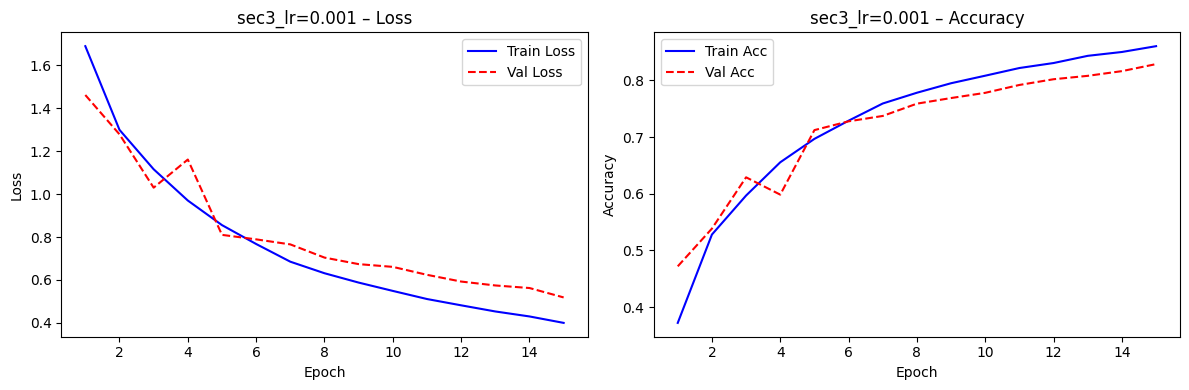

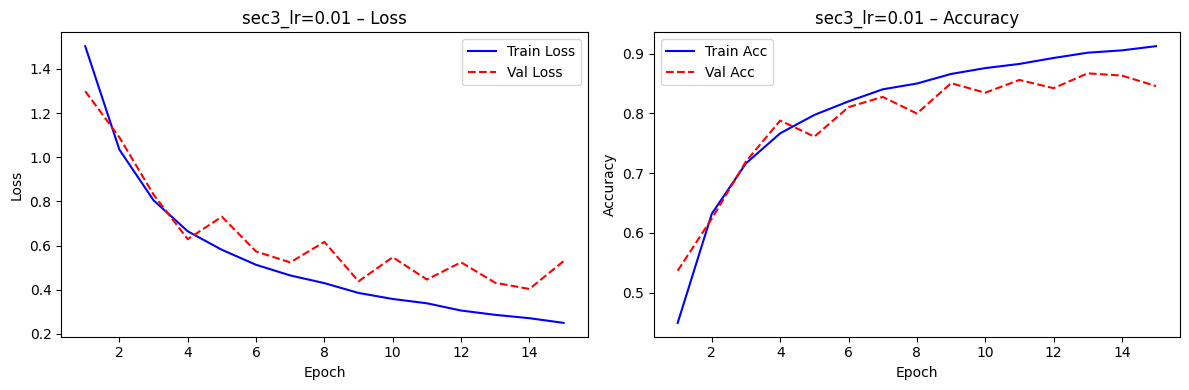

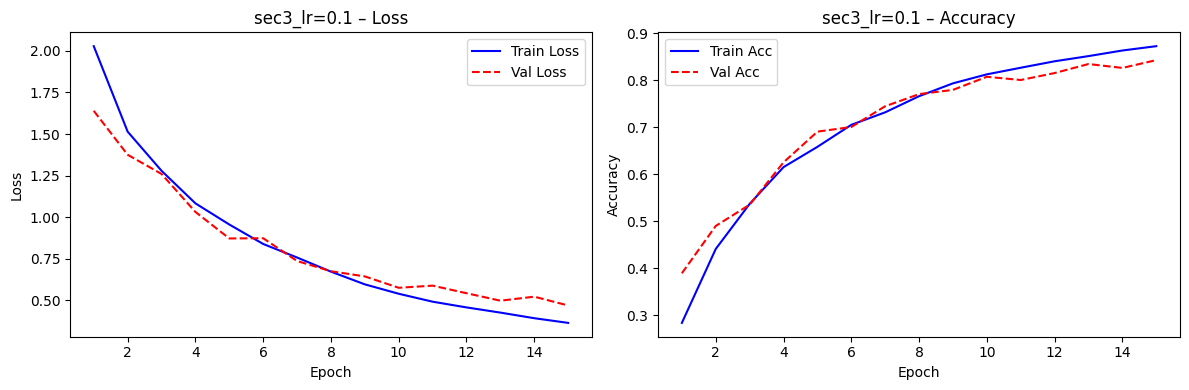

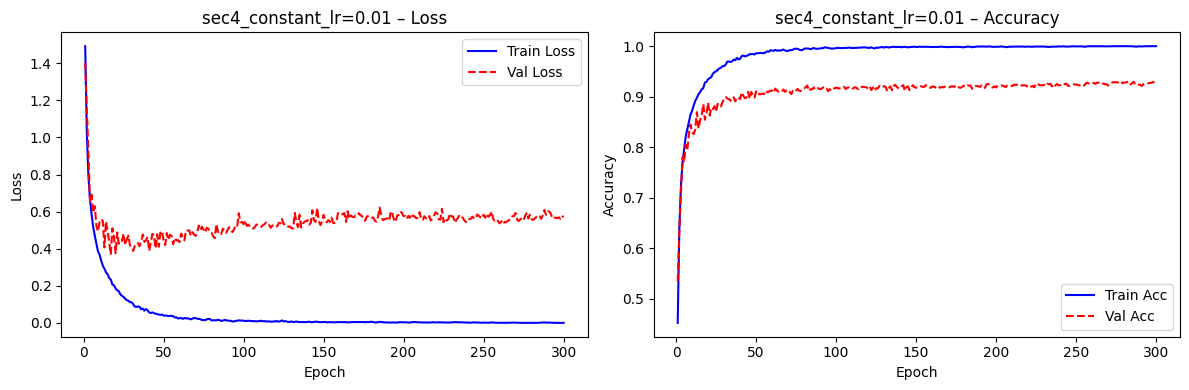

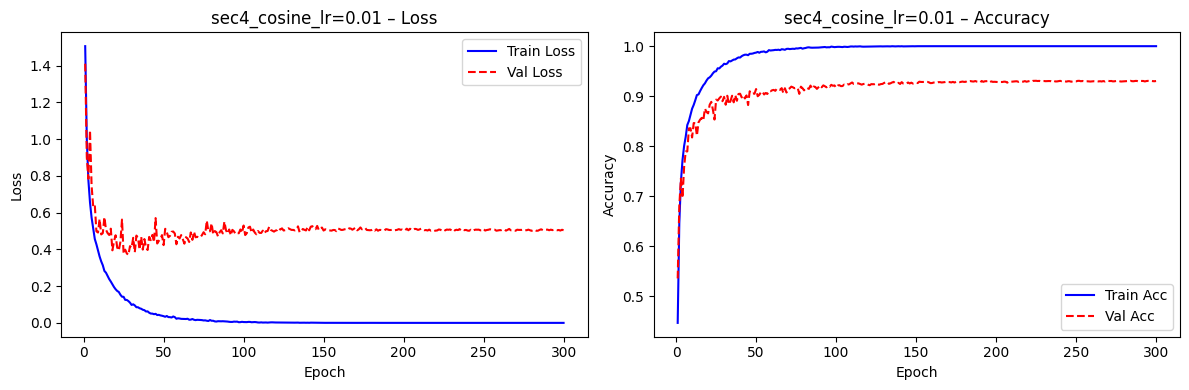

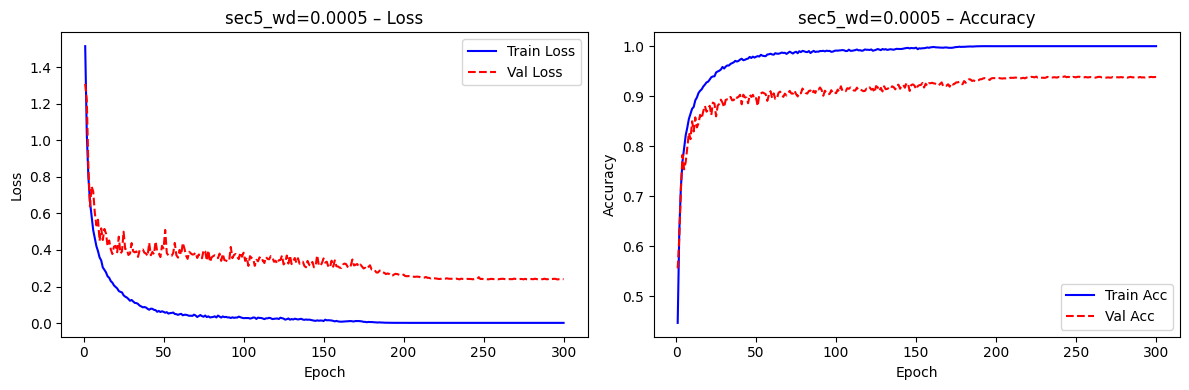

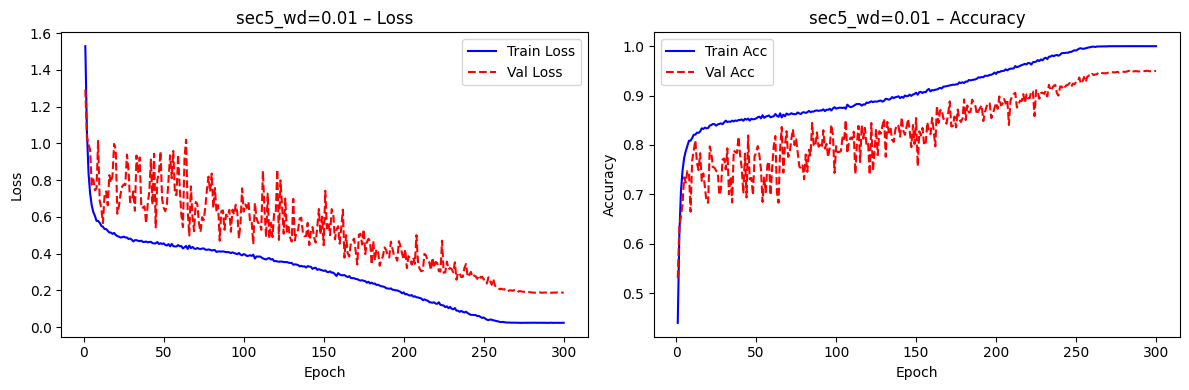

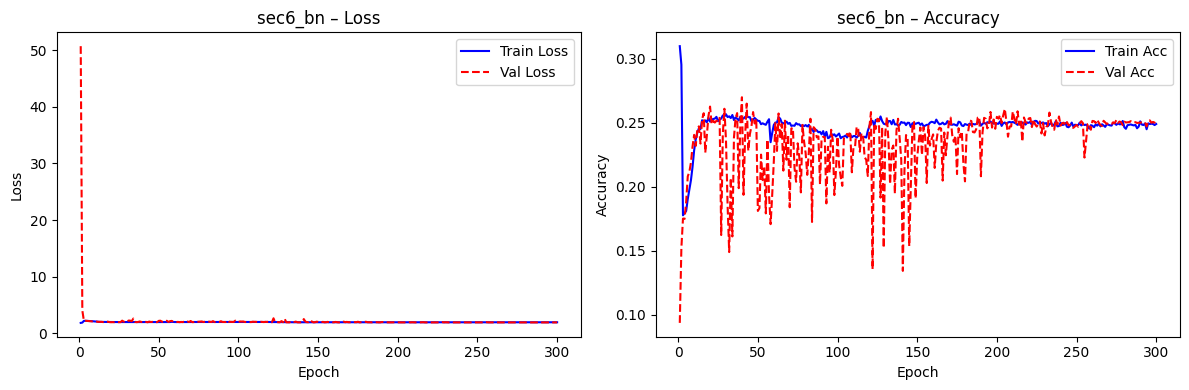

In [4]:
def plot_run_history(entry):
    hist = entry['history']
    epochs = range(1, len(hist['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(epochs, hist['train_loss'],  'b-', label="Train Loss")
    ax1.plot(epochs, hist['val_loss'],    'r--', label="Val Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"{entry['label']} – Loss")
    ax1.legend()

    # Accuracy
    ax2.plot(epochs, hist['train_acc'],   'b-', label="Train Acc")
    ax2.plot(epochs, hist['val_acc'],     'r--', label="Val Acc")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title(f"{entry['label']} – Accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Loop through all loaded runs
for run in logger.results:
    plot_run_history(run)

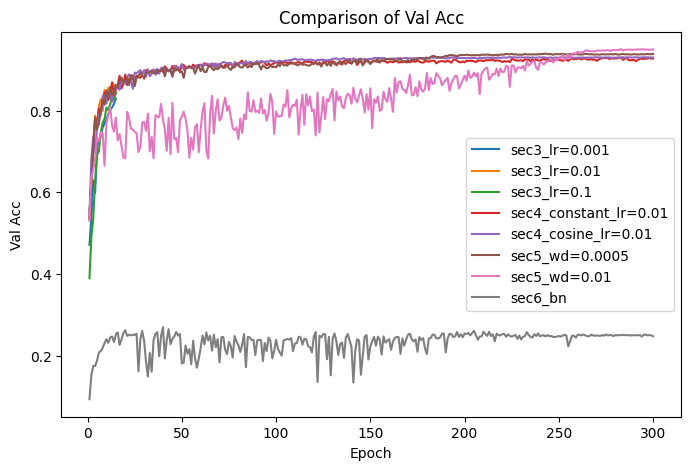

In [5]:
def compare_runs(runs, metric="val_acc"):
    plt.figure(figsize=(8, 5))
    for entry in runs:
        hist = entry['history']
        epochs = range(1, len(hist[metric]) + 1)
        plt.plot(epochs, hist[metric], label=entry['label'])
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"Comparison of {metric.replace('_', ' ').title()}")
    plt.legend()
    plt.show()

compare_runs(logger.results, metric="val_acc")

In [6]:
# Dictionary to hold best run per section
best_per_section = {}

for run in logger.results:
    sec = run['metadata'].get('section', None)
    if sec is None:
        continue
    
    # If this section is new, or this run beats the existing one, replace it
    if (sec not in best_per_section or
        run['final_val'][1] > best_per_section[sec]['final_val'][1]):
        best_per_section[sec] = run

# Print out the winners
for sec, winner in sorted(best_per_section.items()):
    acc = winner['final_val'][1]
    print(f"Section {sec} best: {winner['label']} | val_acc = {acc:.4f}")

Section 3 best: sec3_lr=0.01 | val_acc = 0.8457
Section 4 best: sec4_cosine_lr=0.01 | val_acc = 0.9303
Section 5 best: sec5_wd=0.01 | val_acc = 0.9499
Section 6 best: sec6_bn | val_acc = 0.2477


In [7]:
# Pick the entry with the highest validation accuracy
best_overall = max(
    logger.results,
    key=lambda r: r['final_val'][1]
)

print(f"Best overall run: {best_overall['label']}")
print(f"  → Validation Accuracy = {best_overall['final_val'][1]:.4f}")
print(f"  → Metadata: {best_overall['metadata']}")

Best overall run: sec5_wd=0.01
  → Validation Accuracy = 0.9499
  → Metadata: {'weight_decay': 0.01, 'section': 5, 'added_at': '2025-10-03 22:06:54'}
